<a href="https://colab.research.google.com/github/MuhammadAinurR/PraktikumML_146_180/blob/rizky/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Dataset**
## **https://www.kaggle.com/moltean/fruits**

In [ ]:
import numpy as np
import glob
import pathlib
import PIL
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.convolutional import Conv2D

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"shadowhell","key":"b5416a135b3d1e0e1fbc232ba56e96ce"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

 99% 1.27G/1.28G [00:13<00:00, 95.1MB/s]
100% 1.28G/1.28G [00:13<00:00, 103MB/s] 


In [ ]:
from zipfile import ZipFile
file_name = "fruits.zip"

with ZipFile(file_name,'r') as zip :
  zip.extractall()

In [ ]:
train_path=pathlib.Path("/content/fruits-360_dataset/fruits-360/Training")
test_path=pathlib.Path("/content/fruits-360_dataset/fruits-360/Test")

In [ ]:
image_count=len(list(train_path.glob("*/*.jpg")))
print(image_count)

67692


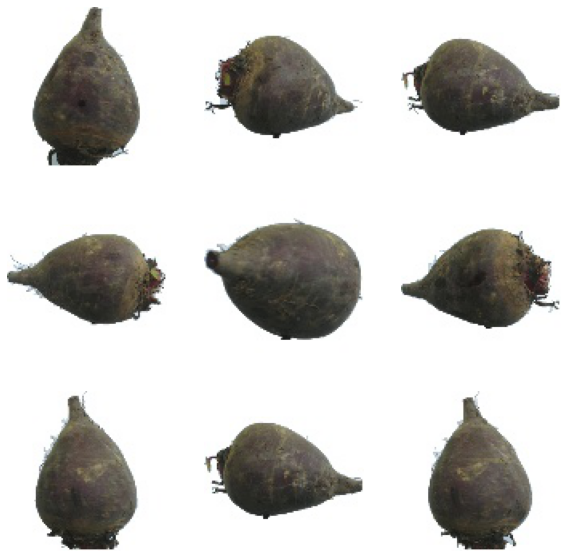

In [ ]:
fruits=list(train_path.glob("Beetroot/*.jpg"))
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    img=PIL.Image.open(str(fruits[i]))
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

In [ ]:
batch_size=32
img_size=(100,100)

In [ ]:
train_ds=tf.keras.preprocessing.image_dataset_from_directory(

train_path,
validation_split=0.2,
subset="training",
seed=42,
image_size=(100,100),
batch_size=32)

Found 67692 files belonging to 131 classes.
Using 54154 files for training.


In [ ]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(

train_path,
validation_split=0.2,
subset="validation",
seed=42,
image_size=(100,100),
batch_size=32)

Found 67692 files belonging to 131 classes.
Using 13538 files for validation.


In [ ]:
class_names=train_ds.class_names
num_class=len(class_names)

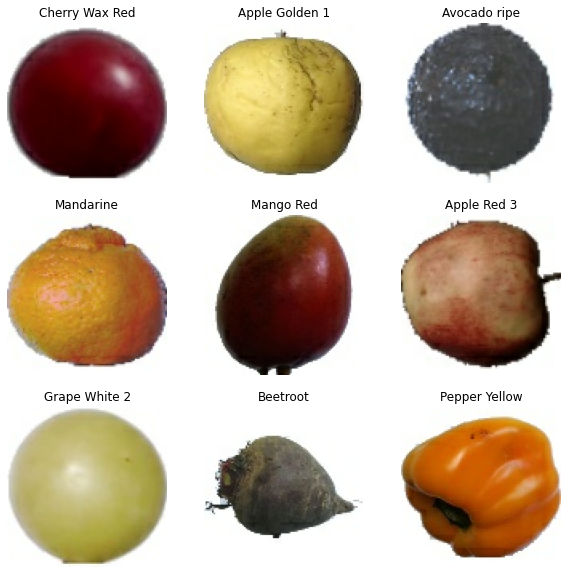

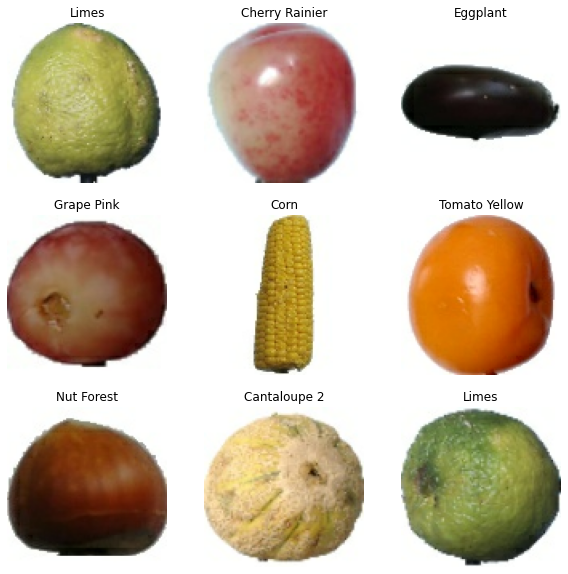

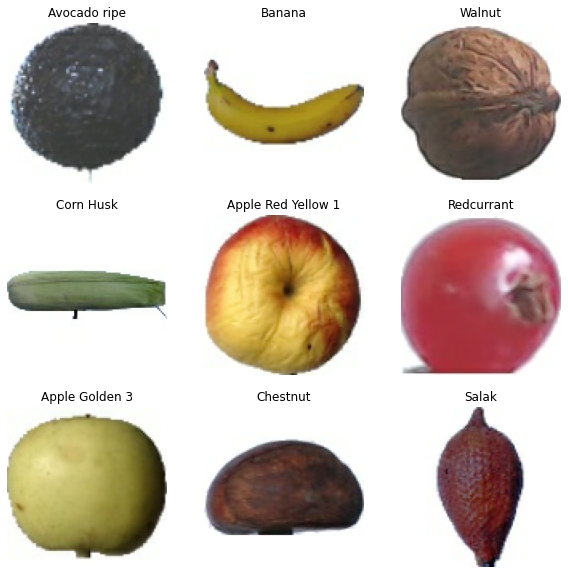

In [ ]:
for images , labels in train_ds.take(3):
    plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
    plt.show()

In [ ]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
preprocess_input=tf.keras.applications.resnet.preprocess_input

In [ ]:
pretrained_model=tf.keras.applications.resnet.ResNet50(
input_shape=(100,100,3),
include_top=False,
weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in pretrained_model.layers:
    layer.trainable=False

In [ ]:
model = Sequential()

model.add(InputLayer(input_shape=[250,250,3]))
model.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(GlobalMaxPooling2D())
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(2, activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 250, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
global_max_pooling2d (Global (None, 64)               

In [ ]:
input=tf.keras.Input(shape=(100,100,3))
x=data_augmentation(input)
x=preprocess_input(x)
x=pretrained_model(x,training=False)
x=tf.keras.layers.GlobalMaxPooling2D()(x)
x=tf.keras.layers.Dropout(0.3)(x)
output=tf.keras.layers.Dense(num_class)(x)

model=tf.keras.Model(inputs=input,outputs=output)

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [ ]:
history=model.fit(train_ds,epochs=100,validation_data=val_ds)

Epoch 1/100
  12/1693 [..............................] - ETA: 31:14 - loss: 18.6852 - accuracy: 0.0026

KeyboardInterrupt: ignored

In [ ]:
import plotly.express as px
fig=px.line(history.history,
           y=["loss","val_loss"],
           labels={"index":"epochs","value":"loss"},
           title="train & val loss")
fig.show()

In [ ]:
fig=px.line(history.history,
           y=["accuracy","val_accuracy"],
           labels={"index":"epochs","value":"acc"},
           title="train & val acc")
fig.show()

In [ ]:
import pickle
model.save('model.h5')

In [ ]:
model2 = Sequential()

model2.add(InputLayer(input_shape=[250,250,3]))
model2.add(Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))
model2.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model2.add(AveragePooling2D(pool_size=2, padding='same'))
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())

# Fully Connected Layer
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

print(model2.summary())

In [ ]:
input=tf.keras.Input(shape=(100,100,3))
x=data_augmentation(input)
x=preprocess_input(x)
x=pretrained_model(x,training=False)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.3)(x)
output=tf.keras.layers.Dense(num_class)(x)

model=tf.keras.Model(inputs=input,outputs=output)

In [ ]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model2.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [ ]:
history=model.fit(train_ds,epochs=100,validation_data=val_ds)

In [ ]:
from sklearn.metrics import classification_report

pred = model.predict(input)
labels = (pred > 0.5).astype(np.int)
print(classification_report(val_ds, labels))